<a href="https://colab.research.google.com/github/nguyenhuy-vn/Finger-identification-based-on-capacitives-touch-screen/blob/main/vgg5_with_left_hand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras import datasets, models, layers

### Load data

In [3]:
X_train = np.load('/content/drive/MyDrive/data for 5/X_train.npy')
X_test = np.load('/content/drive/MyDrive/data for 5/X_test.npy')
X_val = np.load('/content/drive/MyDrive/data for 5/X_val.npy')
Y_train = np.load('/content/drive/MyDrive/data for 5/Y_train.npy')
Y_test = np.load('/content/drive/MyDrive/data for 5/Y_test.npy')
Y_val = np.load('/content/drive/MyDrive/data for 5/Y_val.npy')
label = np.load('/content/drive/MyDrive/data for 5/label.npy')

### Check if have any missing data

In [4]:
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((143120, 32, 32),
 (42967, 32, 32),
 (35780, 32, 32),
 (143120, 5),
 (42967, 5),
 (35780, 5))

In [5]:
X_train[0]

array([[0.        , 0.        , 0.        , ..., 0.01568628, 0.01568628,
        0.01568628],
       [0.        , 0.        , 0.        , ..., 0.01568628, 0.01568628,
        0.01568628],
       [0.        , 0.        , 0.        , ..., 0.01568628, 0.01568628,
        0.01568628],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.15686275, 0.15686275,
        0.15686275],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.15686275, 0.15686275,
        0.15686275],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.15686275, 0.15686275,
        0.15686275]], dtype=float32)

In [6]:
X_val[0]

array([[0.        , 0.        , 0.        , ..., 0.03921569, 0.03921569,
        0.03921569],
       [0.        , 0.        , 0.        , ..., 0.03921569, 0.03921569,
        0.03921569],
       [0.        , 0.        , 0.        , ..., 0.03921569, 0.03921569,
        0.03921569],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.24313726, 0.24313726,
        0.24313726],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.24313726, 0.24313726,
        0.24313726],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.24313726, 0.24313726,
        0.24313726]], dtype=float32)

In [7]:
Y_train[0]

array([1., 0., 0., 0., 0.])

### Model and Train

In [8]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0],32,32,1)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [10]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.models import Model
import tensorflow as tf

class VGG5(Model):
    def __init__(self, num_classes, **kwargs):
        """
        num_classes: number of classes in specific classification task
        """
        super().__init__(**kwargs)

        # Define the convolutional layers with Batch Normalization
        self.conv1 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn2 = BatchNormalization()
        self.pool1 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')

        self.conv3 = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn3 = BatchNormalization()
        self.conv4 = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn4 = BatchNormalization()
        self.pool2 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')

        self.conv5 = Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')
        self.bn5 = BatchNormalization()
        self.pool3 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')

        # Define the fully connected layers with Batch Normalization
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.bn_fc1 = BatchNormalization()
        self.fc2 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        out = self.conv1(inputs)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.pool1(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.pool2(out)

        out = self.conv5(out)
        out = self.bn5(out)
        out = self.pool3(out)

        out = self.flatten(out)
        out = self.fc1(out)
        out = self.bn_fc1(out)
        out = self.fc2(out)

        return out



In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [15]:
model = VGG5(5)
model.build(input_shape = (None, 32, 32, 1))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy", f1_m, precision_m, recall_m])
model.summary()

Model: "vgg5_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           multiple                  640       
                                                                 
 batch_normalization_6 (Bat  multiple                  256       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           multiple                  36928     
                                                                 
 batch_normalization_7 (Bat  multiple                  256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                            

In [16]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs= 50, validation_data=(X_val, Y_val),callbacks=[es])

Epoch 1/50
560/559 [==============================] - ETA: 0s - loss: 1.2227 - accuracy: 0.4845 - f1_m: 0.3906 - precision_m: 0.7017 - recall_m: 0.2729

559/559 [==============================] - 66s 106ms/step - loss: 1.2227 - accuracy: 0.4845 - f1_m: 0.3906 - precision_m: 0.7017 - recall_m: 0.2729 - val_loss: 1.1661 - val_accuracy: 0.4835 - val_f1_m: 0.4376 - val_precision_m: 0.6746 - val_recall_m: 0.3244
Epoch 2/50
560/559 [==============================] - ETA: 0s - loss: 1.0091 - accuracy: 0.5697 - f1_m: 0.5014 - precision_m: 0.7559 - recall_m: 0.3759

559/559 [==============================] - 53s 95ms/step - loss: 1.0091 - accuracy: 0.5697 - f1_m: 0.5014 - precision_m: 0.7559 - recall_m: 0.3759 - val_loss: 1.1101 - val_accuracy: 0.5309 - val_f1_m: 0.4921 - val_precision_m: 0.6533 - val_recall_m: 0.3951
Epoch 3/50
560/559 [==============================] - ETA: 0s - loss: 0.9392 - accuracy: 0.6019 - f1_m: 0.5485 - precision_m: 0.7620 - recall_m: 0.4290

559/559 [==============================] - 52s 93ms/step - loss: 0.9392 - accuracy: 0.6019 - f1_m: 0.5485 - precision_m: 0.7620 - recall_m: 0.4290 - val_loss: 0.9960 - val_accuracy: 0.5830 - val_f1_m: 0.5479 - val_precision_m: 0.7089 - val_recall_m: 0.4468
Epoch 4/50
560/559 [==============================] - ETA: 0s - loss: 0.8788 - accuracy: 0.6298 - f1_m: 0.5882 - precision_m: 0.7678 - recall_m: 0.4774

559/559 [==============================] - 54s 97ms/step - loss: 0.8788 - accuracy: 0.6298 - f1_m: 0.5882 - precision_m: 0.7678 - recall_m: 0.4774 - val_loss: 0.8949 - val_accuracy: 0.6297 - val_f1_m: 0.5995 - val_precision_m: 0.7403 - val_recall_m: 0.5040
Epoch 5/50
560/559 [==============================] - ETA: 0s - loss: 0.8319 - accuracy: 0.6525 - f1_m: 0.6207 - precision_m: 0.7754 - recall_m: 0.5179

559/559 [==============================] - 50s 90ms/step - loss: 0.8319 - accuracy: 0.6525 - f1_m: 0.6207 - precision_m: 0.7754 - recall_m: 0.5179 - val_loss: 0.8377 - val_accuracy: 0.6520 - val_f1_m: 0.6254 - val_precision_m: 0.7773 - val_recall_m: 0.5235
Epoch 6/50
560/559 [==============================] - ETA: 0s - loss: 0.8409 - accuracy: 0.6495 - f1_m: 0.6175 - precision_m: 0.7730 - recall_m: 0.5150

559/559 [==============================] - 52s 94ms/step - loss: 0.8409 - accuracy: 0.6495 - f1_m: 0.6175 - precision_m: 0.7730 - recall_m: 0.5150 - val_loss: 0.9328 - val_accuracy: 0.6184 - val_f1_m: 0.5908 - val_precision_m: 0.7202 - val_recall_m: 0.5011
Epoch 7/50
560/559 [==============================] - ETA: 0s - loss: 0.7757 - accuracy: 0.6800 - f1_m: 0.6563 - precision_m: 0.7888 - recall_m: 0.5623

559/559 [==============================] - 51s 92ms/step - loss: 0.7757 - accuracy: 0.6800 - f1_m: 0.6563 - precision_m: 0.7888 - recall_m: 0.5623 - val_loss: 0.9114 - val_accuracy: 0.6272 - val_f1_m: 0.6088 - val_precision_m: 0.7266 - val_recall_m: 0.5242
Epoch 8/50
560/559 [==============================] - ETA: 0s - loss: 0.7781 - accuracy: 0.6811 - f1_m: 0.6577 - precision_m: 0.7864 - recall_m: 0.5662

559/559 [==============================] - 51s 91ms/step - loss: 0.7781 - accuracy: 0.6811 - f1_m: 0.6577 - precision_m: 0.7864 - recall_m: 0.5662 - val_loss: 0.7993 - val_accuracy: 0.6723 - val_f1_m: 0.6456 - val_precision_m: 0.7780 - val_recall_m: 0.5521
Epoch 9/50
560/559 [==============================] - ETA: 0s - loss: 0.7300 - accuracy: 0.7016 - f1_m: 0.6828 - precision_m: 0.7994 - recall_m: 0.5962

559/559 [==============================] - 53s 94ms/step - loss: 0.7300 - accuracy: 0.7016 - f1_m: 0.6828 - precision_m: 0.7994 - recall_m: 0.5962 - val_loss: 0.8750 - val_accuracy: 0.6504 - val_f1_m: 0.6337 - val_precision_m: 0.7408 - val_recall_m: 0.5541
Epoch 10/50
560/559 [==============================] - ETA: 0s - loss: 0.7020 - accuracy: 0.7157 - f1_m: 0.6998 - precision_m: 0.8059 - recall_m: 0.6188

559/559 [==============================] - 55s 98ms/step - loss: 0.7020 - accuracy: 0.7157 - f1_m: 0.6998 - precision_m: 0.8059 - recall_m: 0.6188 - val_loss: 0.7250 - val_accuracy: 0.7071 - val_f1_m: 0.6956 - val_precision_m: 0.7831 - val_recall_m: 0.6259
Epoch 11/50
560/559 [==============================] - ETA: 0s - loss: 0.6676 - accuracy: 0.7298 - f1_m: 0.7179 - precision_m: 0.8133 - recall_m: 0.6428

559/559 [==============================] - 52s 93ms/step - loss: 0.6676 - accuracy: 0.7298 - f1_m: 0.7179 - precision_m: 0.8133 - recall_m: 0.6428 - val_loss: 0.7503 - val_accuracy: 0.6976 - val_f1_m: 0.6861 - val_precision_m: 0.7868 - val_recall_m: 0.6085
Epoch 12/50
560/559 [==============================] - ETA: 0s - loss: 0.6479 - accuracy: 0.7385 - f1_m: 0.7279 - precision_m: 0.8175 - recall_m: 0.6563

559/559 [==============================] - 51s 92ms/step - loss: 0.6479 - accuracy: 0.7385 - f1_m: 0.7279 - precision_m: 0.8175 - recall_m: 0.6563 - val_loss: 0.7651 - val_accuracy: 0.6893 - val_f1_m: 0.6783 - val_precision_m: 0.7688 - val_recall_m: 0.6071
Epoch 13/50
560/559 [==============================] - ETA: 0s - loss: 0.6252 - accuracy: 0.7491 - f1_m: 0.7403 - precision_m: 0.8232 - recall_m: 0.6727

559/559 [==============================] - 52s 93ms/step - loss: 0.6252 - accuracy: 0.7491 - f1_m: 0.7403 - precision_m: 0.8232 - recall_m: 0.6727 - val_loss: 0.7038 - val_accuracy: 0.7221 - val_f1_m: 0.7140 - val_precision_m: 0.7984 - val_recall_m: 0.6460
Epoch 14/50
560/559 [==============================] - ETA: 0s - loss: 0.6073 - accuracy: 0.7569 - f1_m: 0.7495 - precision_m: 0.8292 - recall_m: 0.6841

559/559 [==============================] - 51s 91ms/step - loss: 0.6073 - accuracy: 0.7569 - f1_m: 0.7495 - precision_m: 0.8292 - recall_m: 0.6841 - val_loss: 0.6643 - val_accuracy: 0.7342 - val_f1_m: 0.7294 - val_precision_m: 0.8084 - val_recall_m: 0.6647
Epoch 15/50
560/559 [==============================] - ETA: 0s - loss: 0.5884 - accuracy: 0.7670 - f1_m: 0.7601 - precision_m: 0.8343 - recall_m: 0.6983

559/559 [==============================] - 54s 97ms/step - loss: 0.5884 - accuracy: 0.7670 - f1_m: 0.7601 - precision_m: 0.8343 - recall_m: 0.6983 - val_loss: 0.6303 - val_accuracy: 0.7535 - val_f1_m: 0.7495 - val_precision_m: 0.8147 - val_recall_m: 0.6942
Epoch 16/50
560/559 [==============================] - ETA: 0s - loss: 0.5682 - accuracy: 0.7746 - f1_m: 0.7687 - precision_m: 0.8381 - recall_m: 0.7101

559/559 [==============================] - 54s 96ms/step - loss: 0.5682 - accuracy: 0.7746 - f1_m: 0.7687 - precision_m: 0.8381 - recall_m: 0.7101 - val_loss: 0.6455 - val_accuracy: 0.7427 - val_f1_m: 0.7387 - val_precision_m: 0.8130 - val_recall_m: 0.6772
Epoch 17/50
560/559 [==============================] - ETA: 0s - loss: 0.5470 - accuracy: 0.7837 - f1_m: 0.7793 - precision_m: 0.8448 - recall_m: 0.7233

559/559 [==============================] - 51s 91ms/step - loss: 0.5470 - accuracy: 0.7837 - f1_m: 0.7793 - precision_m: 0.8448 - recall_m: 0.7233 - val_loss: 0.6966 - val_accuracy: 0.7259 - val_f1_m: 0.7209 - val_precision_m: 0.7825 - val_recall_m: 0.6685
Epoch 18/50
560/559 [==============================] - ETA: 0s - loss: 0.5335 - accuracy: 0.7892 - f1_m: 0.7854 - precision_m: 0.8465 - recall_m: 0.7328

559/559 [==============================] - 52s 94ms/step - loss: 0.5335 - accuracy: 0.7892 - f1_m: 0.7854 - precision_m: 0.8465 - recall_m: 0.7328 - val_loss: 0.8173 - val_accuracy: 0.6871 - val_f1_m: 0.6826 - val_precision_m: 0.7447 - val_recall_m: 0.6302
Epoch 19/50
560/559 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.7984 - f1_m: 0.7944 - precision_m: 0.8526 - recall_m: 0.7439

559/559 [==============================] - 53s 95ms/step - loss: 0.5135 - accuracy: 0.7984 - f1_m: 0.7944 - precision_m: 0.8526 - recall_m: 0.7439 - val_loss: 0.6124 - val_accuracy: 0.7639 - val_f1_m: 0.7630 - val_precision_m: 0.8156 - val_recall_m: 0.7170
Epoch 20/50
560/559 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.8032 - f1_m: 0.7999 - precision_m: 0.8553 - recall_m: 0.7515

559/559 [==============================] - 51s 91ms/step - loss: 0.5032 - accuracy: 0.8032 - f1_m: 0.7999 - precision_m: 0.8553 - recall_m: 0.7515 - val_loss: 0.6028 - val_accuracy: 0.7664 - val_f1_m: 0.7640 - val_precision_m: 0.8180 - val_recall_m: 0.7170
Epoch 21/50
560/559 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.8110 - f1_m: 0.8094 - precision_m: 0.8618 - recall_m: 0.7633

559/559 [==============================] - 50s 90ms/step - loss: 0.4822 - accuracy: 0.8110 - f1_m: 0.8094 - precision_m: 0.8618 - recall_m: 0.7633 - val_loss: 0.5779 - val_accuracy: 0.7772 - val_f1_m: 0.7758 - val_precision_m: 0.8256 - val_recall_m: 0.7318
Epoch 22/50
560/559 [==============================] - ETA: 0s - loss: 0.4689 - accuracy: 0.8171 - f1_m: 0.8147 - precision_m: 0.8644 - recall_m: 0.7705

559/559 [==============================] - 55s 98ms/step - loss: 0.4689 - accuracy: 0.8171 - f1_m: 0.8147 - precision_m: 0.8644 - recall_m: 0.7705 - val_loss: 0.5810 - val_accuracy: 0.7747 - val_f1_m: 0.7754 - val_precision_m: 0.8262 - val_recall_m: 0.7307
Epoch 23/50
560/559 [==============================] - ETA: 0s - loss: 0.4592 - accuracy: 0.8216 - f1_m: 0.8193 - precision_m: 0.8669 - recall_m: 0.7768

559/559 [==============================] - 52s 93ms/step - loss: 0.4592 - accuracy: 0.8216 - f1_m: 0.8193 - precision_m: 0.8669 - recall_m: 0.7768 - val_loss: 0.6068 - val_accuracy: 0.7668 - val_f1_m: 0.7651 - val_precision_m: 0.8175 - val_recall_m: 0.7192
Epoch 24/50
560/559 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.8282 - f1_m: 0.8268 - precision_m: 0.8709 - recall_m: 0.7870

559/559 [==============================] - 52s 92ms/step - loss: 0.4447 - accuracy: 0.8282 - f1_m: 0.8268 - precision_m: 0.8709 - recall_m: 0.7870 - val_loss: 0.5505 - val_accuracy: 0.7920 - val_f1_m: 0.7906 - val_precision_m: 0.8404 - val_recall_m: 0.7465
Epoch 25/50
560/559 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.8295 - f1_m: 0.8278 - precision_m: 0.8705 - recall_m: 0.7893

559/559 [==============================] - 51s 91ms/step - loss: 0.4436 - accuracy: 0.8295 - f1_m: 0.8278 - precision_m: 0.8705 - recall_m: 0.7893 - val_loss: 0.7666 - val_accuracy: 0.7024 - val_f1_m: 0.6982 - val_precision_m: 0.7666 - val_recall_m: 0.6412
Epoch 26/50
560/559 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.8253 - f1_m: 0.8230 - precision_m: 0.8696 - recall_m: 0.7813

559/559 [==============================] - 53s 95ms/step - loss: 0.4497 - accuracy: 0.8253 - f1_m: 0.8230 - precision_m: 0.8696 - recall_m: 0.7813 - val_loss: 0.5661 - val_accuracy: 0.7857 - val_f1_m: 0.7857 - val_precision_m: 0.8277 - val_recall_m: 0.7480
Epoch 27/50
560/559 [==============================] - ETA: 0s - loss: 0.4053 - accuracy: 0.8439 - f1_m: 0.8421 - precision_m: 0.8816 - recall_m: 0.8062

559/559 [==============================] - 55s 99ms/step - loss: 0.4053 - accuracy: 0.8439 - f1_m: 0.8421 - precision_m: 0.8816 - recall_m: 0.8062 - val_loss: 0.5328 - val_accuracy: 0.8001 - val_f1_m: 0.7995 - val_precision_m: 0.8402 - val_recall_m: 0.7627
Epoch 28/50
560/559 [==============================] - ETA: 0s - loss: 0.3976 - accuracy: 0.8464 - f1_m: 0.8453 - precision_m: 0.8828 - recall_m: 0.8109

559/559 [==============================] - 53s 95ms/step - loss: 0.3976 - accuracy: 0.8464 - f1_m: 0.8453 - precision_m: 0.8828 - recall_m: 0.8109 - val_loss: 0.5475 - val_accuracy: 0.7991 - val_f1_m: 0.7998 - val_precision_m: 0.8351 - val_recall_m: 0.7674
Epoch 29/50
560/559 [==============================] - ETA: 0s - loss: 0.3850 - accuracy: 0.8530 - f1_m: 0.8510 - precision_m: 0.8858 - recall_m: 0.8190

559/559 [==============================] - 52s 93ms/step - loss: 0.3850 - accuracy: 0.8530 - f1_m: 0.8510 - precision_m: 0.8858 - recall_m: 0.8190 - val_loss: 0.5539 - val_accuracy: 0.7951 - val_f1_m: 0.7943 - val_precision_m: 0.8311 - val_recall_m: 0.7608
Epoch 30/50
560/559 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.8569 - f1_m: 0.8566 - precision_m: 0.8903 - recall_m: 0.8254

559/559 [==============================] - 52s 93ms/step - loss: 0.3717 - accuracy: 0.8569 - f1_m: 0.8566 - precision_m: 0.8903 - recall_m: 0.8254 - val_loss: 0.5336 - val_accuracy: 0.8046 - val_f1_m: 0.8055 - val_precision_m: 0.8388 - val_recall_m: 0.7748
Epoch 31/50
560/559 [==============================] - ETA: 0s - loss: 0.3596 - accuracy: 0.8633 - f1_m: 0.8626 - precision_m: 0.8939 - recall_m: 0.8336

559/559 [==============================] - 51s 91ms/step - loss: 0.3596 - accuracy: 0.8633 - f1_m: 0.8626 - precision_m: 0.8939 - recall_m: 0.8336 - val_loss: 1.0314 - val_accuracy: 0.6732 - val_f1_m: 0.6726 - val_precision_m: 0.7071 - val_recall_m: 0.6415
Epoch 32/50
560/559 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.8649 - f1_m: 0.8640 - precision_m: 0.8948 - recall_m: 0.8353

559/559 [==============================] - 54s 96ms/step - loss: 0.3555 - accuracy: 0.8649 - f1_m: 0.8640 - precision_m: 0.8948 - recall_m: 0.8353 - val_loss: 0.5874 - val_accuracy: 0.7912 - val_f1_m: 0.7929 - val_precision_m: 0.8231 - val_recall_m: 0.7649
Epoch 33/50
560/559 [==============================] - ETA: 0s - loss: 0.3465 - accuracy: 0.8685 - f1_m: 0.8679 - precision_m: 0.8967 - recall_m: 0.8410

559/559 [==============================] - 55s 98ms/step - loss: 0.3465 - accuracy: 0.8685 - f1_m: 0.8679 - precision_m: 0.8967 - recall_m: 0.8410 - val_loss: 0.5612 - val_accuracy: 0.7999 - val_f1_m: 0.8003 - val_precision_m: 0.8312 - val_recall_m: 0.7716
Epoch 34/50
560/559 [==============================] - ETA: 0s - loss: 0.3436 - accuracy: 0.8693 - f1_m: 0.8689 - precision_m: 0.8974 - recall_m: 0.8423

559/559 [==============================] - 52s 92ms/step - loss: 0.3436 - accuracy: 0.8693 - f1_m: 0.8689 - precision_m: 0.8974 - recall_m: 0.8423 - val_loss: 0.5512 - val_accuracy: 0.8024 - val_f1_m: 0.8042 - val_precision_m: 0.8336 - val_recall_m: 0.7769
Epoch 35/50
560/559 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.8777 - f1_m: 0.8776 - precision_m: 0.9035 - recall_m: 0.8531

559/559 [==============================] - 53s 94ms/step - loss: 0.3233 - accuracy: 0.8777 - f1_m: 0.8776 - precision_m: 0.9035 - recall_m: 0.8531 - val_loss: 0.5402 - val_accuracy: 0.8055 - val_f1_m: 0.8072 - val_precision_m: 0.8383 - val_recall_m: 0.7784
Epoch 36/50
560/559 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.8814 - f1_m: 0.8817 - precision_m: 0.9063 - recall_m: 0.8584

559/559 [==============================] - 52s 93ms/step - loss: 0.3131 - accuracy: 0.8814 - f1_m: 0.8817 - precision_m: 0.9063 - recall_m: 0.8584 - val_loss: 0.5718 - val_accuracy: 0.8030 - val_f1_m: 0.8045 - val_precision_m: 0.8313 - val_recall_m: 0.7795
Epoch 37/50
560/559 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.8811 - f1_m: 0.8810 - precision_m: 0.9052 - recall_m: 0.8582

559/559 [==============================] - 51s 92ms/step - loss: 0.3144 - accuracy: 0.8811 - f1_m: 0.8810 - precision_m: 0.9052 - recall_m: 0.8582 - val_loss: 0.6497 - val_accuracy: 0.7793 - val_f1_m: 0.7815 - val_precision_m: 0.8079 - val_recall_m: 0.7568
Epoch 38/50
560/559 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.8874 - f1_m: 0.8873 - precision_m: 0.9101 - recall_m: 0.8658

559/559 [==============================] - 52s 93ms/step - loss: 0.2974 - accuracy: 0.8874 - f1_m: 0.8873 - precision_m: 0.9101 - recall_m: 0.8658 - val_loss: 0.5417 - val_accuracy: 0.8166 - val_f1_m: 0.8181 - val_precision_m: 0.8417 - val_recall_m: 0.7958
Epoch 39/50
560/559 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.8912 - f1_m: 0.8914 - precision_m: 0.9125 - recall_m: 0.8713

559/559 [==============================] - 56s 99ms/step - loss: 0.2860 - accuracy: 0.8912 - f1_m: 0.8914 - precision_m: 0.9125 - recall_m: 0.8713 - val_loss: 0.5546 - val_accuracy: 0.8113 - val_f1_m: 0.8122 - val_precision_m: 0.8364 - val_recall_m: 0.7894
Epoch 40/50
560/559 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.8912 - f1_m: 0.8908 - precision_m: 0.9119 - recall_m: 0.8707

559/559 [==============================] - 53s 95ms/step - loss: 0.2903 - accuracy: 0.8912 - f1_m: 0.8908 - precision_m: 0.9119 - recall_m: 0.8707 - val_loss: 0.5513 - val_accuracy: 0.8144 - val_f1_m: 0.8162 - val_precision_m: 0.8392 - val_recall_m: 0.7945
Epoch 41/50
560/559 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.8977 - f1_m: 0.8981 - precision_m: 0.9177 - recall_m: 0.8793

559/559 [==============================] - 51s 92ms/step - loss: 0.2714 - accuracy: 0.8977 - f1_m: 0.8981 - precision_m: 0.9177 - recall_m: 0.8793 - val_loss: 0.5244 - val_accuracy: 0.8238 - val_f1_m: 0.8248 - val_precision_m: 0.8474 - val_recall_m: 0.8035
Epoch 42/50
560/559 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.9018 - f1_m: 0.9022 - precision_m: 0.9206 - recall_m: 0.8846

559/559 [==============================] - 52s 92ms/step - loss: 0.2586 - accuracy: 0.9018 - f1_m: 0.9022 - precision_m: 0.9206 - recall_m: 0.8846 - val_loss: 0.6334 - val_accuracy: 0.7997 - val_f1_m: 0.8004 - val_precision_m: 0.8202 - val_recall_m: 0.7816
Epoch 43/50
560/559 [==============================] - ETA: 0s - loss: 0.2670 - accuracy: 0.8989 - f1_m: 0.8990 - precision_m: 0.9176 - recall_m: 0.8813

559/559 [==============================] - 50s 90ms/step - loss: 0.2670 - accuracy: 0.8989 - f1_m: 0.8990 - precision_m: 0.9176 - recall_m: 0.8813 - val_loss: 0.5518 - val_accuracy: 0.8197 - val_f1_m: 0.8224 - val_precision_m: 0.8432 - val_recall_m: 0.8026
Epoch 44/50
560/559 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.9081 - f1_m: 0.9086 - precision_m: 0.9255 - recall_m: 0.8924

559/559 [==============================] - 54s 97ms/step - loss: 0.2445 - accuracy: 0.9081 - f1_m: 0.9086 - precision_m: 0.9255 - recall_m: 0.8924 - val_loss: 0.5420 - val_accuracy: 0.8282 - val_f1_m: 0.8294 - val_precision_m: 0.8466 - val_recall_m: 0.8129
Epoch 45/50
560/559 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.9076 - f1_m: 0.9075 - precision_m: 0.9233 - recall_m: 0.8924

559/559 [==============================] - 54s 97ms/step - loss: 0.2473 - accuracy: 0.9076 - f1_m: 0.9075 - precision_m: 0.9233 - recall_m: 0.8924 - val_loss: 0.5367 - val_accuracy: 0.8255 - val_f1_m: 0.8276 - val_precision_m: 0.8484 - val_recall_m: 0.8079
Epoch 46/50
560/559 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9131 - f1_m: 0.9135 - precision_m: 0.9286 - recall_m: 0.8991

559/559 [==============================] - 53s 94ms/step - loss: 0.2323 - accuracy: 0.9131 - f1_m: 0.9135 - precision_m: 0.9286 - recall_m: 0.8991 - val_loss: 0.5820 - val_accuracy: 0.8149 - val_f1_m: 0.8171 - val_precision_m: 0.8362 - val_recall_m: 0.7988
Epoch 47/50
560/559 [==============================] - ETA: 0s - loss: 0.2275 - accuracy: 0.9152 - f1_m: 0.9158 - precision_m: 0.9302 - recall_m: 0.9018

559/559 [==============================] - 52s 93ms/step - loss: 0.2275 - accuracy: 0.9152 - f1_m: 0.9158 - precision_m: 0.9302 - recall_m: 0.9018 - val_loss: 0.5403 - val_accuracy: 0.8332 - val_f1_m: 0.8348 - val_precision_m: 0.8511 - val_recall_m: 0.8192
Epoch 48/50
560/559 [==============================] - ETA: 0s - loss: 0.2257 - accuracy: 0.9160 - f1_m: 0.9163 - precision_m: 0.9300 - recall_m: 0.9031

559/559 [==============================] - 51s 91ms/step - loss: 0.2257 - accuracy: 0.9160 - f1_m: 0.9163 - precision_m: 0.9300 - recall_m: 0.9031 - val_loss: 0.5385 - val_accuracy: 0.8338 - val_f1_m: 0.8344 - val_precision_m: 0.8500 - val_recall_m: 0.8194
Epoch 49/50
560/559 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.9127 - f1_m: 0.9129 - precision_m: 0.9273 - recall_m: 0.8991

559/559 [==============================] - 53s 95ms/step - loss: 0.2345 - accuracy: 0.9127 - f1_m: 0.9129 - precision_m: 0.9273 - recall_m: 0.8991 - val_loss: 0.6111 - val_accuracy: 0.8129 - val_f1_m: 0.8136 - val_precision_m: 0.8318 - val_recall_m: 0.7963
Epoch 50/50
560/559 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.9193 - f1_m: 0.9198 - precision_m: 0.9332 - recall_m: 0.9068

559/559 [==============================] - 53s 95ms/step - loss: 0.2166 - accuracy: 0.9193 - f1_m: 0.9198 - precision_m: 0.9332 - recall_m: 0.9068 - val_loss: 0.5601 - val_accuracy: 0.8297 - val_f1_m: 0.8310 - val_precision_m: 0.8467 - val_recall_m: 0.8160


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


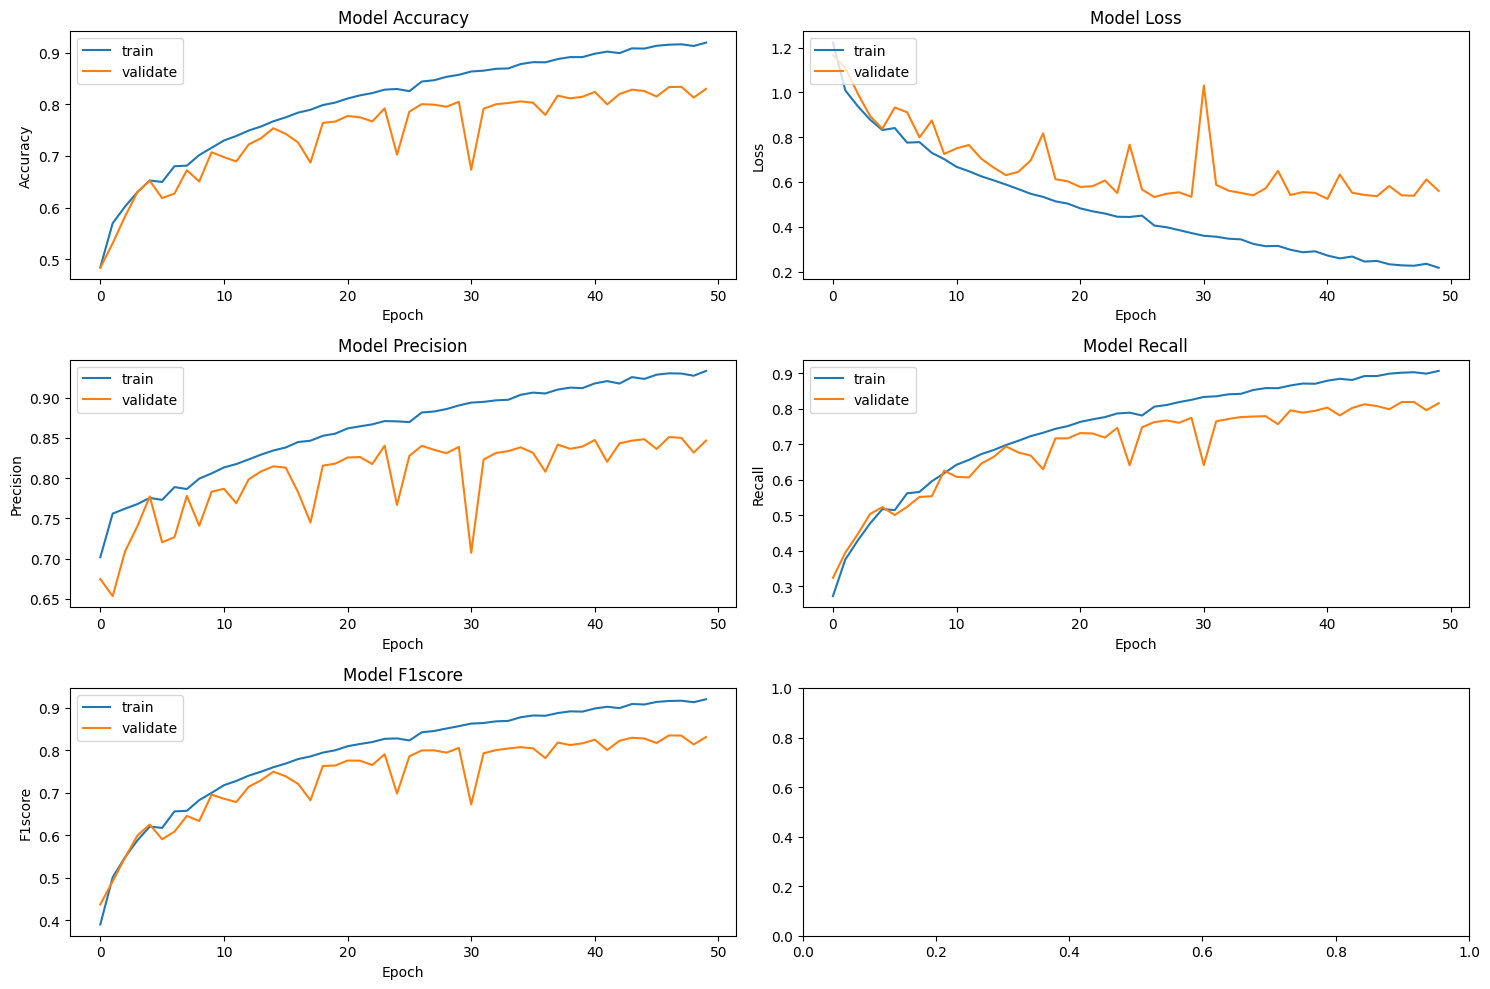

In [17]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))

    # Plot accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['train', 'validate'], loc='upper left')

    # Plot loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['train', 'validate'], loc='upper left')

    # Plot precision_m
    axs[1, 0].plot(history.history['precision_m'])
    axs[1, 0].plot(history.history['val_precision_m'])
    axs[1, 0].set_title('Model Precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['train', 'validate'], loc='upper left')

    # Plot recall_m
    axs[1, 1].plot(history.history['recall_m'])
    axs[1, 1].plot(history.history['val_recall_m'])
    axs[1, 1].set_title('Model Recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['train', 'validate'], loc='upper left')

    # Plot f1score_m
    axs[2, 0].plot(history.history['f1_m'])
    axs[2, 0].plot(history.history['val_f1_m'])
    axs[2, 0].set_title('Model F1score')
    axs[2, 0].set_ylabel('F1score')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['train', 'validate'], loc='upper left')

    plt.tight_layout()
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [18]:
lost_test, accuracy_test, f1score_test, precision_test, recall_test = model.evaluate(X_test, Y_test, verbose=0)
print("Loss of test set is: ",lost_test)
print("Accuracy of test set is: ",accuracy_test)
print("F1score of test set is: ",f1score_test)
print("Precision of test set is: ",precision_test)
print("Recall of test set is: ",recall_test)

Loss of test set is:  3.2405290603637695
Accuracy of test set is:  0.45309191942214966
F1score of test set is:  0.4469131827354431
Precision of test set is:  0.4612656831741333
Recall of test set is:  0.4346875250339508


### Draw confusion matrix

In [19]:
label

array(['left middle', 'left ring', 'left thumb', 'left little',
       'left index'], dtype='<U11')

In [20]:
labels = list(label)
labels

['left middle', 'left ring', 'left thumb', 'left little', 'left index']

4473/4473 [==============================] - 13s 3ms/step


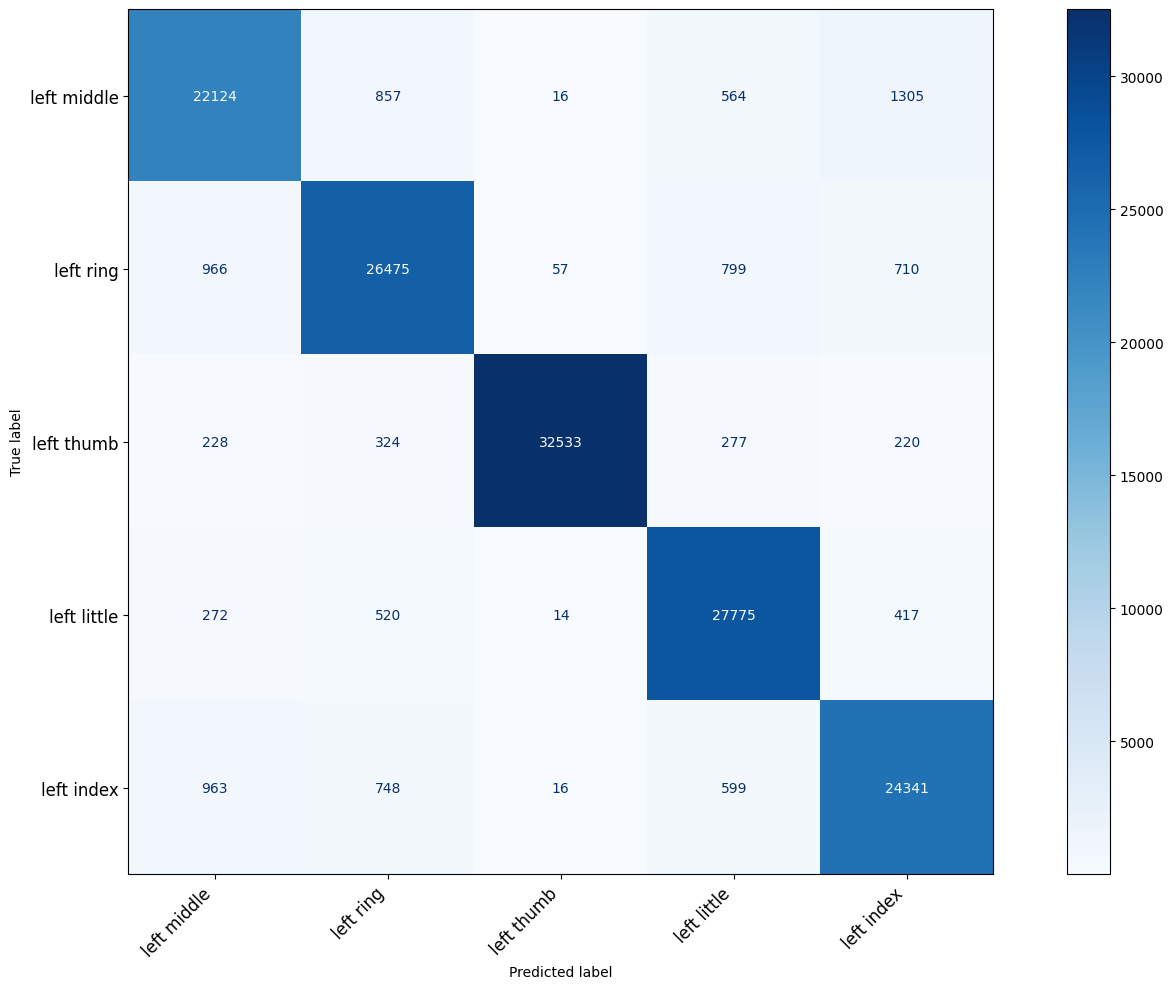

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_train, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


In [22]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((143120, 32, 32, 1), (143120, 5), (42967, 32, 32, 1), (42967, 5))

1343/1343 [==============================] - 4s 3ms/step


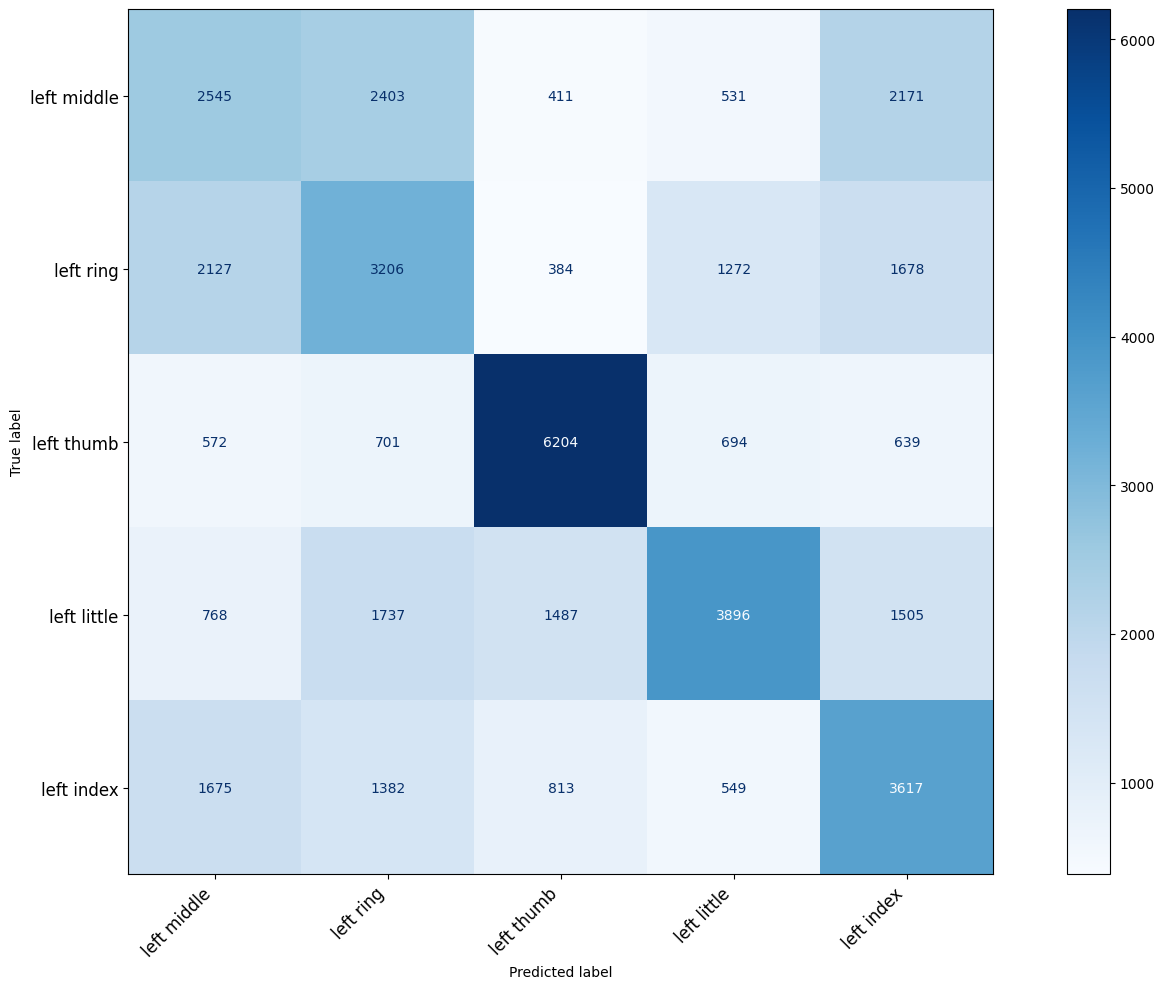

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()
